<a href="https://colab.research.google.com/github/tanaxer01/mov-in-covid/blob/main/index_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ ! -d mov-in-covid ]; then \
  git clone https://github.com/tanaxer01/mov-in-covid; \
  mv mov-in-covid/*.py .; fi

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import utils

In [ ]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
  # DP...
}

for name, url in datasets.items():
  utils.get_file(name, url)

[+] created ./datos/
[+] downloaded ./datos/dp1_contagios
[+] downloaded ./datos/dp51_difs
[+] downloaded ./datos/dp82_weeks
[+] downloaded ./datos/dp82_weekends


# DATASET PREP

## DP1

(275,)


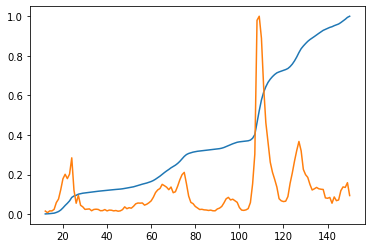

In [ ]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ DataProduct1["Codigo region"] == 13 ].drop(columns=["Region", "Codigo region"])

print(DataProduct1[ DataProduct1.Comuna == "Santiago" ]["Fecha"].shape)

DataProduct1 = DataProduct1.set_index("Fecha")

# Week num
DataProduct1["Semana"] = (DataProduct1.index.to_series() - datetime.strptime("2020-01-01", "%Y-%m-%d")).dt.days // 7

# Drop `Desconocido Metropolitana`
DataProduct1 = DataProduct1[ DataProduct1.Comuna != "Desconocido Metropolitana" ]

casos = pd.DataFrame({ i:DataProduct1[ DataProduct1.Comuna == i ].groupby("Semana")["Casos confirmados"].mean() for i in set(DataProduct1.Comuna) }) 
casos_nuevos = casos.subtract( casos.shift(periods=1, fill_value=0) )

#casos_old = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna")
#casos_oldnuevos = casos.subtract( casos.shift(periods=1, fill_value=0) )

DataProduct1.head(2)

plt.figure()
plt.plot(casos["Santiago"] / casos["Santiago"].max())
plt.plot(casos_nuevos["Santiago"] / casos_nuevos["Santiago"].max())

plt.show()

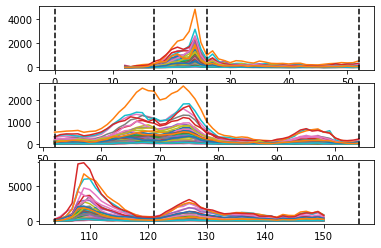

In [ ]:
date2week = lambda x: (datetime.strptime(x, "%Y-%m-%d") - datetime.strptime("2020-01-01", "%Y-%m-%d")).days // 7

plt.subplot(3,1,1)
plt.plot( casos_nuevos.loc[:date2week("2021-01-01")] )

for i in ["2020-01-01", "2020-05-01", "2020-07-01", "2020-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.subplot(3,1,2)
plt.plot( casos_nuevos.loc[date2week("2021-01-01"):date2week("2022-01-01")] )

for i in ["2021-01-01", "2021-05-01", "2021-07-01", "2021-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.subplot(3,1,3)
plt.plot( casos_nuevos.loc[date2week("2022-01-01"):] )

for i in ["2022-01-01", "2022-05-01", "2022-07-01", "2022-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.show()

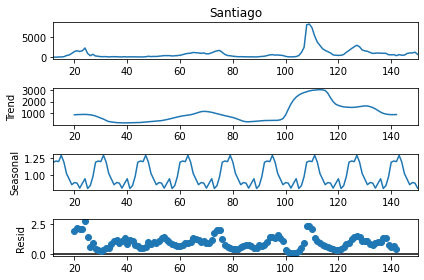

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(casos_nuevos["Santiago"], period=16, model="multiplicative").plot()

## DP51
link: [product51](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto51)


In [ ]:
df_difs = pd.read_csv("./datos/dp51_difs.csv")

# Fecha to Datetime && sort by Fecha
df_difs['Fecha'] = pd.to_datetime(df_difs['Fecha'])
df_difs = df_difs.sort_values(by=['Fecha'])

# Just RM
df_difs = df_difs[ df_difs['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region'])


# Calc prom of Dif salida y Dif entrada.
def parse_diff(x):
  mean = sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2
  
  return (100 + mean)/100

df_difs['Salida'] = df_difs['Dif salida'].map(parse_diff)
df_difs['Entrada'] = df_difs['Dif entrada'].map(parse_diff)

df_salidas  = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Week")["Salida"].mean() for i in set(df_difs["Comuna"]) })
df_entradas = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Week")["Entrada"].mean() for i in set(df_difs["Comuna"]) })

In [ ]:
df_salidas.head()

,Calera de Tango,Isla de Maipo,Cerrillos,María Pinto,Melipilla,Peñaflor,La Florida,San Bernardo,Maipú,Quilicura,...,Curacaví,Independencia,Macul,Santiago,Pedro Aguirre Cerda,Pudahuel,Paine,El Bosque,Providencia,Recoleta
Week,,,,,,,,,,,,,,,,,,,,,
9,1.265000,1.1975,1.149286,1.670000,1.711538,1.072143,1.184252,1.173676,1.177093,1.193000,...,1.29875,1.119615,1.176212,1.101744,1.139643,1.204032,1.128125,1.265000,1.026765,1.265000
10,1.265000,1.1975,1.149286,1.670000,1.711538,1.072143,1.184252,1.173676,1.177093,1.193000,...,1.29875,1.119615,1.166818,1.101744,1.139643,1.204032,1.146875,1.265000,1.026765,1.265000
11,1.198333,1.1225,1.120714,1.620000,1.700000,1.015000,1.133785,1.151618,1.121279,1.159667,...,1.29875,1.119615,1.057727,1.027326,1.139643,1.175000,1.040625,1.257308,0.748333,1.218333
12,1.020556,0.9850,0.977857,1.586667,1.669231,0.886429,0.978645,1.029559,0.996473,1.039667,...,1.18625,0.923462,0.948636,0.849031,0.968214,1.025000,0.865625,1.172692,0.624804,1.140556
13,1.020556,0.9475,0.949286,1.586667,1.653846,0.848333,0.985187,1.013382,0.996473,1.035222,...,1.22375,0.915769,0.912273,0.790891,0.946786,1.039516,0.871875,1.149615,0.564020,1.098333


## DP82
link: [product82](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto82)

In [ ]:
df_weeks = pd.read_csv('./datos/dp82_weeks.csv')
#df_weekends = pd.read_csv('./datos/dp82_weekends.csv')

# Fecha to Datetime && sort by Fecha
df_weeks['fecha_inicio'] = pd.to_datetime(df_weeks['fecha_inicio'])
df_weeks = df_weeks.sort_values(by=['fecha_inicio'])

# Just RM
df_weeks = df_weeks[ df_weeks['region'] == 13 ].drop(columns=['region'])

# Just dates on DP51
# df_weeks = df_weeks[ df_weeks["fecha_inicio"].isin(df_difs["Fecha"]) ]

# [!] Fill pasos 
df_weeks["paso"] = df_weeks["paso"].fillna(method="ffill")

# DF pasos
df_pasos = df_weeks.pivot_table(values='paso', index='semana', columns='nom_comuna')


var_salidas = df_weeks.pivot_table(values="var_salidas", index="semana", columns="nom_comuna")

df_weeks.head(1)

,semana,paso,nom_comuna,comuna,fecha_inicio,fecha_termino,var_salidas,var_salidas_cota_inferior,var_salidas_cota_superior
11544,9,0.0,PUDAHUEL,13124,2020-03-02,2020-03-06,0.988342,0.985605,0.99108


## `Dif salida` VS `var_salidas`
En general siguen las mismas tendencias, pero tienen una diferencia de 0.2 que no estoy seguro pq ocurre.
Lo unico raro es la diferencia al final, (el peak hacia abajo es por un error de mediciones en uno de los datasets.) pero al final, el dataset `var` tiene un amuento raro que no se ve en la otra curva.

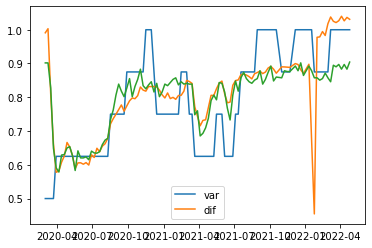

'shift promedio entre var y dif: 0.19000725738526164'

In [ ]:
dif  = df_salidas["Santiago"]
var  = df_weeks[ df_weeks["nom_comuna"] == "SANTIAGO" ].set_index("fecha_inicio")

var_salidas = var["var_salidas"]
paso = var["paso"]

plt.figure()

plt.plot(paso / 8 + 0.5)
plt.plot(var_salidas)
plt.plot(dif - 0.2)

plt.legend(["var", "dif"])
plt.show()

f"shift promedio entre var y dif: {(dif - var_salidas).mean()}"

# Medición de eficiencia

## Base model

In [ ]:
from sklearn.model_selection import train_test_split

semanas = [ i for i in var_salidas.index if i in casos.index]

X = var_salidas.loc[semanas].rename(columns={ i:"IM-"+i for i in var_salidas.columns }).join(df_pasos.rename(columns={ i:"paso-"+i for i in df_pasos.columns }))
y = casos.loc[semanas]["Santiago"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Mean squared error: 2762278153.39
Coefficient of determination: -2.62
-1777.98 accuracy with a standard deviation of 3661.01 AKA it sucks


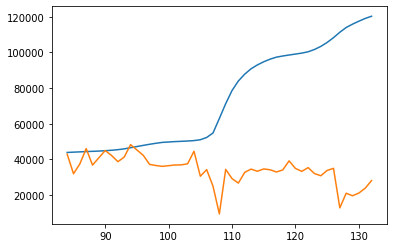

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

reg = linear_model.LinearRegression()
reg.fit(X.head(70),y.head(70))

y_pred = reg.predict(X.tail(47))

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y.tail(47), y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y.tail(47), y_pred))

scores = cross_val_score(reg, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f AKA it sucks" % (scores.mean(), scores.std()))

plt.figure()
plt.plot(y.tail(47))
plt.plot(y.tail(47).index, y_pred)

plt.show()

## First Aproach

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

test_stationarity(casos_nuevos.Santiago)

Results of Dickey-Fuller Test:
Test Statistic                  -4.353
p-value                          0.000
#Lags Used                       1.000
Number of Observations Used    137.000
Critical Value (1%)             -3.479
Critical Value (5%)             -2.883
Critical Value (10%)            -2.578
dtype: float64


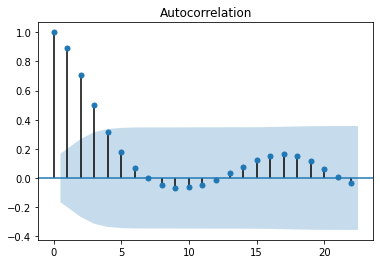

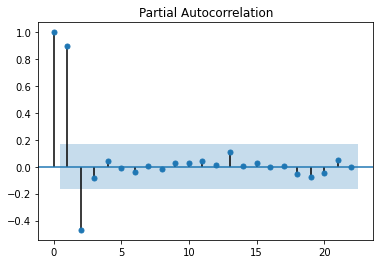

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf = plot_acf(casos_nuevos.Santiago)
pacf = plot_pacf(casos_nuevos.Santiago)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

week2day = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

start = max(casos_nuevos.loc[:52].index.min(), var_salidas.loc[:52].index.min())
end   = max(casos_nuevos.loc[:52].index.max(), var_salidas.loc[:52].index.max())


endo = pd.Series(casos_nuevos.loc[:52]["Santiago"], index=[ week2day(i) for i in range(12,52) ])
exo  = pd.DataFrame(var_salidas.loc[:52], index=[ week2day(i) for i in range(12,52) ]).interpolate()

index = pd.date_range(week2day(int(start)), periods=40, freq='W-WED')
endo.index = index
exo.index  = index

def sarimax(ts, exo, all_params):
  results = []
  for param in all_params:
    try:
      mod = SARIMAX(endo, exog=exo, order=param[0], seasonal_order=param[1])
      res = mod.fit()

      results.append((res, res.aic,param))
      print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))

    except Exception as e:
      print(e)
      continue

  return results

In [ ]:
#test_a = pd.Series(casos_nuevos.loc[:52]["Santiago"], index=range(12,52))
#test_b = pd.DataFrame(var_salidas.loc[:52], index=range(12,52)).interpolate()

#pd.infer_freq(index)
b = pd.date_range(week2day(int(start)), periods=40, freq='W-WED')

#endo.asfreq("W-WED")
display(exo.index)
display(endo.index)

DatetimeIndex(['2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15',
               '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13',
               '2020-05-20', '2020-05-27', '2020-06-03', '2020-06-10',
               '2020-06-17', '2020-06-24', '2020-07-01', '2020-07-08',
               '2020-07-15', '2020-07-22', '2020-07-29', '2020-08-05',
               '2020-08-12', '2020-08-19', '2020-08-26', '2020-09-02',
               '2020-09-09', '2020-09-16', '2020-09-23', '2020-09-30',
               '2020-10-07', '2020-10-14', '2020-10-21', '2020-10-28',
               '2020-11-04', '2020-11-11', '2020-11-18', '2020-11-25',
               '2020-12-02', '2020-12-09', '2020-12-16', '2020-12-23'],
              dtype='datetime64[ns]', freq='W-WED')

DatetimeIndex(['2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15',
               '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13',
               '2020-05-20', '2020-05-27', '2020-06-03', '2020-06-10',
               '2020-06-17', '2020-06-24', '2020-07-01', '2020-07-08',
               '2020-07-15', '2020-07-22', '2020-07-29', '2020-08-05',
               '2020-08-12', '2020-08-19', '2020-08-26', '2020-09-02',
               '2020-09-09', '2020-09-16', '2020-09-23', '2020-09-30',
               '2020-10-07', '2020-10-14', '2020-10-21', '2020-10-28',
               '2020-11-04', '2020-11-11', '2020-11-18', '2020-11-25',
               '2020-12-02', '2020-12-09', '2020-12-16', '2020-12-23'],
              dtype='datetime64[ns]', freq='W-WED')

In [ ]:
import itertools

# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(endo,exo,all_param)

exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contains inf or nans
exog contain